In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cpu')

In [ ]:
imsize = (512 if device == 'cuda' else 256)
imsize

256

In [ ]:
def load_image (image_path):
  image = Image.open(image_path)
  return image

def resize_image(input_image, output_image):
  input_image_resized = input_image.resize(output_image.size)
  return input_image_resized

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
loader = transforms.Compose([
    transforms.Resize((imsize)),
    transforms.ToTensor(),
])

def process_image(image_name):
    image = loader(image_name).unsqueeze(0)
    return image.to(device, torch.float)

style_image = load_image ("/content/drive/MyDrive/Anh My/DIP/style1.jpg")
content_image = load_image("/content/drive/MyDrive/Anh My/DIP/content.jpg")
content_image_resized = resize_image(content_image, style_image)
style_img = process_image(style_image)
content_img = process_image(content_image_resized)

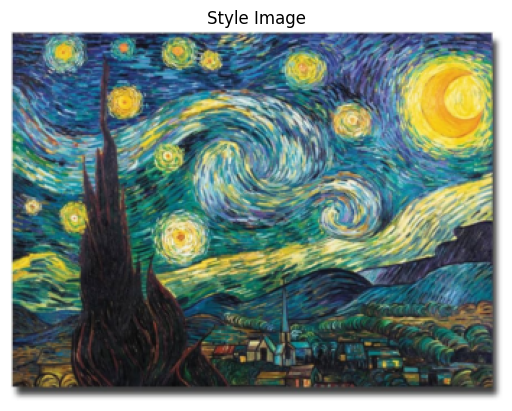

torch.Size([1, 3, 256, 341])


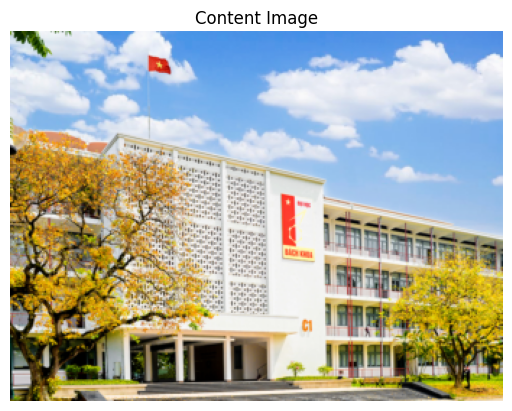

torch.Size([1, 3, 256, 341])


In [ ]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')
print (style_img.shape)

plt.figure()
imshow(content_img, title='Content Image')
print (content_img.shape)

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn,
                               normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    content_losses = []
    style_losses = []

    normalization = Normalization (normalization_mean, normalization_std)
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

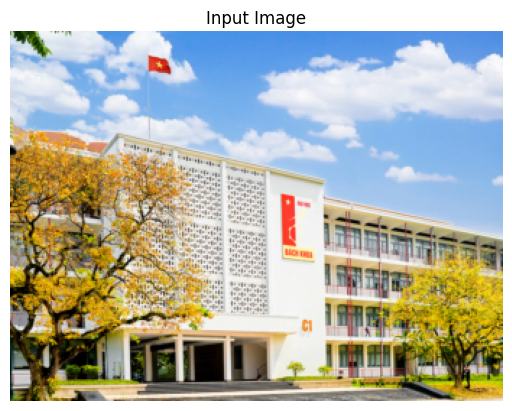

In [ ]:
input_img = content_img.clone()
imshow(input_img, title='Input Image')

In [ ]:
class EarlyStoppingNST:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.stop = False

    def __call__(self, current_loss):
        if self.best_loss is None:
            self.best_loss = current_loss
        elif self.best_loss - current_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_loss = current_loss
            self.counter = 0

In [ ]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [47]:
def run_style_transfer(cnn,
                       normalization_mean, normalization_std,
                       content_img, style_img, input_img,
                       num_steps=500,
                       style_weight=10000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                     normalization_mean, normalization_std,
                                                                     style_img, content_img)

    input_img.requires_grad_(True)

    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return loss

        loss = optimizer.step(closure).item()

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model
Optimizing
run [50]:
Style Loss : 1.917387 Content Loss: 5.251565

run [100]:
Style Loss : 1.833014 Content Loss: 5.150500

run [150]:
Style Loss : 1.797985 Content Loss: 5.135668

run [200]:
Style Loss : 1.799884 Content Loss: 5.171696

run [250]:
Style Loss : 1.990697 Content Loss: 5.670478

run [300]:
Style Loss : 1.871630 Content Loss: 5.269247

run [350]:
Style Loss : 1.892806 Content Loss: 5.425581

run [400]:
Style Loss : 2.096259 Content Loss: 5.848973

run [450]:
Style Loss : 2.104089 Content Loss: 5.882957

run [500]:
Style Loss : 3.746647 Content Loss: 11.564307



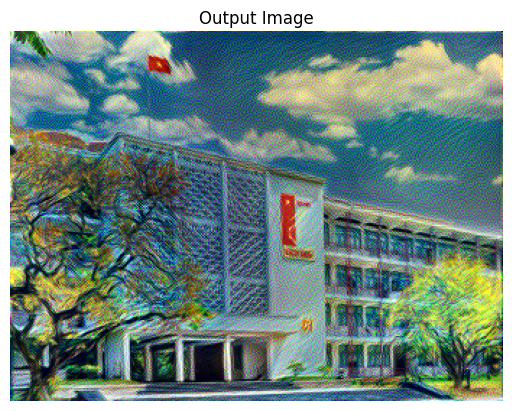

In [48]:
output = run_style_transfer(cnn,
                            cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()
